# Machine learning using EKF

In [1]:
from IPython import display
import os
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import seaborn as sns
from load import load_abalone_data,load_bikes_data,load_wine_data
# Importing Pytorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import mean_absolute_error,mean_squared_error
import matplotlib as mpl
mpl.rcParams['figure.dpi']=150

In [2]:
# Select device which you are going to use for training
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)

cpu


### Import Data Sets
Testing using a toy sine data

In [3]:
X,y = load_bikes_data()
print(y.shape)
print(X.shape)

(17379,)
(17379, 14)


## Data Partition


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=.5)
X_val,X_test, y_val,y_test = train_test_split(X_test,y_test,test_size=0.5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
# x_train_scaled = scaler.fit_transform(x_train)
# x_test_scaled = scaler.transform(x_test)

(8689, 14)
(4345, 14)
(4345, 14)


## Define Neural network

In [33]:
class MLP(nn.Module):
    def __init__(self, n_inputs, n_hidden_layer, n_outputs,bias=True):
        super(MLP, self).__init__()
        # YOUR CODE HERE
        #raise NotImplementedError()
        self.fc1 = nn.Linear(n_inputs, n_hidden_layer, bias)
        self.fc2 = nn.Linear(n_hidden_layer, n_hidden_layer, bias)
        #self.fc3 = nn.Linear(n_hidden_layer, n_hidden_layer, bias)
        self.fc4 = nn.Linear(n_hidden_layer, n_outputs, bias)
        

    def forward(self, x):
        # YOUR CODE HERE
        #raise NotImplementedError()
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        #x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x    

In [34]:
## Testing net
n_inputs = X.shape[1]
n_outputs = 1
n_hidden_layer = 100
test_net = MLP(n_inputs, n_hidden_layer, n_outputs)
print(test_net)

MLP(
  (fc1): Linear(in_features=14, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=1, bias=True)
)


In [35]:
# Define number of Input and Output layers
torch.set_default_dtype(torch.float64)
n_inputs = X.shape[1]
n_outputs = 1
n_hidden_layer = 10
mlp = MLP(n_inputs,n_hidden_layer, n_outputs)
mpl = mlp.to(device)

optimizer = torch.optim.Adam(mlp.parameters(), lr=0.005)
n_epochs = 10000

train_accuracy_history = []
test_accuracy_history = []
x_tensor = torch.tensor(X_train, device=device, dtype=torch.float64)
y_tensor = torch.tensor(y_train[:,None], device=device, dtype=torch.float64)
x_val_tensor = torch.tensor(X_val, device=device, dtype=torch.float64)
print_every = 1000
ceLoss = nn.MSELoss()


pbar = tqdm(range(n_epochs))
train_error =[]
RMS =[]

patience  = 100
tolerance = 1e-3
for epoch in pbar:
    
    #Set gradients as zero
    mlp.zero_grad()
    #Calculate outputs with forward()
    outputs = mlp(x_tensor)
    #calculate loss
    loss = ceLoss(outputs, y_tensor)
#     print(f"The output is :{outputs.item()} expected is :{y_train}")
    #calculate gradients - calling backward()
    loss.backward()

    #update weights using optimizer
    optimizer.step()
    
    train_error.append(np.sqrt(loss.item()))
    with torch.no_grad():
            y_pred = mlp.forward(x_val_tensor)
            y_pred = y_pred.cpu().data.numpy()
            error = mean_squared_error(y_val,y_pred)
            val_error =  np.sqrt(error)
            RMS.append(val_error)
    
    # Early stopping 
    if len(RMS)>patience and np.alltrue(RMS[-patience:] > min(RMS)+tolerance) :
        print(f"Early Stopping after {epoch+1} epochs")
        break
    pbar.set_description(f"Train Error: {train_error[-1]:.2e}, Val Error: {RMS[-1]:.2e}")
#     if(epoch%print_every ==0):
#         with torch.no_grad():
#             y_pred = mlp.forward(x_val_tensor)
#             y_pred = y_pred.cpu().data.numpy()
#             error = mean_squared_error(y_val,y_pred)
#             val_error =  np.sqrt(error)
#         print(f"Epoch:{epoch} train error: {np.sqrt(loss.item())} val error:{val_error.item()}")

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
with torch.no_grad():
    x_test = torch.tensor(X_test, device=device, dtype=torch.float64)
    y_pred = mlp.forward(x_test)
    y_pred = y_pred.cpu().data.numpy()
    error = mean_squared_error(y_test,y_pred)
    print(np.sqrt(error))

0.2642348495902115


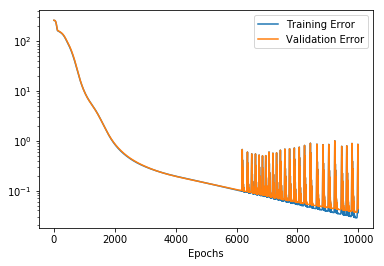

In [37]:
plt.plot(range(len(train_error)),train_error,label="Training Error")
plt.plot(range(len(RMS)),RMS, label= "Validation Error")
plt.legend()
plt.yscale('log')
plt.xlabel("Epochs")
plt.show()